In [ ]:
import tensorflow as tf

# Create a function to import an image and resize it to be able to be used with our model
def load_and_prep_image(filename, img_shape=224, scale=True):
  """
  Reads in an image from filename, turns it into a tensor and reshapes into
  (224, 224, 3).
  Parameters
  ----------
  filename (str): string filename of target image
  img_shape (int): size to resize target image to, default 224
  scale (bool): whether to scale pixel values to range(0, 1), default True
  """
  # Read in the image
  img = tf.io.read_file(filename)
  # Decode it into a tensor
  img = tf.image.decode_jpeg(img)
  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])
  if scale:
    # Rescale the image (get all values between 0 and 1)
    return img/255.
  else:
    return img

# Note: The following confusion matrix code is a remix of Scikit-Learn's 
# plot_confusion_matrix function - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.
  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.
  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.
  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")
  
# Make a function to predict on images and plot them (works with multi-class)
def pred_and_plot(model, filename, class_names):
  """
  Imports an image located at filename, makes a prediction on it with
  a trained model and plots the image with the predicted class as the title.
  """
  # Import the target image and preprocess it
  img = load_and_prep_image(filename)

  # Make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0))

  # Get the predicted class
  if len(pred[0]) > 1: # check for multi-class
    pred_class = class_names[pred.argmax()] # if more than one output, take the max
  else:
    pred_class = class_names[int(tf.round(pred)[0][0])] # if only one output, round

  # Plot the image and predicted class
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False);
  
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  """
  Creates a TensorBoard callback instand to store log files.
  Stores log files with the filepath:
    "dir_name/experiment_name/current_datetime/"
  Args:
    dir_name: target directory to store TensorBoard log files
    experiment_name: name of experiment directory (e.g. efficientnet_model_1)
  """
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

# Plot the validation and training data separately
import matplotlib.pyplot as plt

def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  Args:
    history: TensorFlow model History object (see: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History)
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

def compare_historys(original_history, new_history, initial_epochs=5):
    """
    Compares two TensorFlow model History objects.
    
    Args:
      original_history: History object from original model (before new_history)
      new_history: History object from continued model training (after original_history)
      initial_epochs: Number of epochs in original_history (new_history plot starts from here) 
    """
    
    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()
  
# Create function to unzip a zipfile into current working directory 
# (since we're going to be downloading and unzipping a few files)
import zipfile

def unzip_data(filename):
  """
  Unzips filename into the current working directory.
  Args:
    filename (str): a filepath to a target zip folder to be unzipped.
  """
  zip_ref = zipfile.ZipFile(filename, "r")
  zip_ref.extractall()
  zip_ref.close()

# Walk through an image classification directory and find out how many files (images)
# are in each subdirectory.
import os

def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.
  Args:
    dir_path (str): target directory
  
  Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")
    
# Function to evaluate: accuracy, precision, recall, f1-score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.
  Args:
      y_true: true labels in the form of a 1D array
      y_pred: predicted labels in the form of a 1D array
  Returns a dictionary of accuracy, precision, recall, f1-score.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

In [ ]:
!nvidia-smi

Thu Mar 17 15:56:58 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip

unzip_data("101_food_classes_10_percent.zip")

train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

--2022-03-17 15:56:58--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.182.128, 64.233.183.128, 173.194.194.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.182.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G   143MB/s    in 13s     

2022-03-17 15:57:11 (119 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [ ]:
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/train'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/eggs_benedict'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/deviled_eggs'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/mussels'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/sashimi'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/oysters'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/cheesecake'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/hot_and_sour_soup'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/lobster_roll_sandwich'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/tiramisu'.
There are 0 directories and 75 images

In [ ]:
import tensorflow as tf
IMG_SIZE = (224,224)

train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                 label_mode="categorical",
                                                                                 image_size = IMG_SIZE
                                                                                 )


test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size = IMG_SIZE,
                                                                shuffle = False)



Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


In [ ]:
checkpoint_path = "101_classes_10_percent_data_model_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weigts_only = True,
                                                         monitor = "val_accuracy",
                                                         save_best_only = True)


In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

data_augmentation = Sequential([
            preprocessing.RandomFlip("horizontal"),
            preprocessing.RandomRotation(0.2),
            preprocessing.RandomHeight(0.2), 
            preprocessing.RandomWidth(0.2), 
            preprocessing.RandomZoom(0.2)
], name = "data_augmentation")

In [ ]:
base_model = tf.keras.applications.EfficientNetB0(include_top = False)
base_model.trainable = False

inputs = layers.Input(shape = (224,224,3), name = "input_layer")
x = base_model(inputs, training = False)
x = layers.GlobalAveragePooling2D(name = "global_average_pooling")(x)
outputs = layers.Dense(len(train_data_all_10_percent.class_names), activation = "softmax", name = "output_layer")(x)
model = tf.keras.Model(inputs, outputs)

16719872/16705208 [==============================] - 0s 0us/step


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling (Glo  (None, 1280)             0         
 balAveragePooling2D)                                            
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_________________________________________________________________


In [ ]:
model.compile(loss = "categorical_crossentropy",
              optimizer = tf.keras.optimizers.Adam(),
              metrics = ["accuracy"])

history_all_classes_10_percent_nonaug = model.fit(train_data_all_10_percent,
                                           epochs = 5,
                                           validation_data = test_data,
                                           validation_steps=int(0.15*len(test_data)),
                                           callbacks = [checkpoint_callback])

Epoch 1/5
237/237 [==============================] - 111s 397ms/step - loss: 3.1597 - accuracy: 0.3225 - val_loss: 2.4681 - val_accuracy: 0.4513
Epoch 2/5
237/237 [==============================] - 94s 396ms/step - loss: 1.8603 - accuracy: 0.5872 - val_loss: 2.0422 - val_accuracy: 0.5013
Epoch 3/5
237/237 [==============================] - 94s 393ms/step - loss: 1.4493 - accuracy: 0.6669 - val_loss: 1.9051 - val_accuracy: 0.5127
Epoch 4/5
237/237 [==============================] - 92s 387ms/step - loss: 1.2008 - accuracy: 0.7336 - val_loss: 1.8334 - val_accuracy: 0.5238
Epoch 5/5
237/237 [==============================] - 95s 399ms/step - loss: 1.0234 - accuracy: 0.7814 - val_loss: 1.7821 - val_accuracy: 0.5328


In [ ]:
results_feature_extraction_model = model.evaluate(test_data)
results_feature_extraction_model

790/790 [==============================] - 103s 131ms/step - loss: 1.5323 - accuracy: 0.6002


[1.532271146774292, 0.6001980304718018]

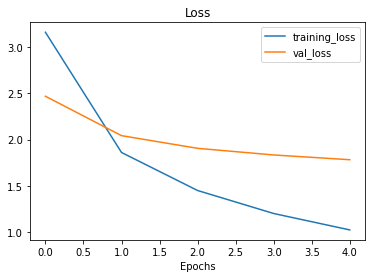

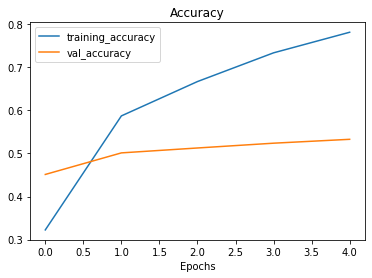

In [ ]:
plot_loss_curves(history_all_classes_10_percent_nonaug)

In [ ]:
base_model.trainable = True

for layer in base_model.layers[:-5]:
  layer.trainable  = False

In [ ]:
model.compile(loss = "categorical_crossentropy",
              optimizer = tf.keras.optimizers.Adam(1e-4),
              metrics = ["accuracy"])

In [ ]:
for layer in model.layers:
  print(layer.name, layer.trainable)

input_layer True
efficientnetb0 True
global_average_pooling True
output_layer True


In [ ]:
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_reshape F

In [ ]:
fine_tune_epochs = 10

history_all_classes_10_percent_fine_tune = model.fit(train_data_all_10_percent,
                                                     epochs = fine_tune_epochs,
                                                     validation_data = test_data,
                                                     validation_steps = int(0.15*len(test_data)),
                                                     initial_epoch = history_all_classes_10_percent_nonaug.epoch[-1])

Epoch 5/10
237/237 [==============================] - 57s 204ms/step - loss: 0.7617 - accuracy: 0.8215 - val_loss: 1.7828 - val_accuracy: 0.5355
Epoch 6/10
237/237 [==============================] - 47s 197ms/step - loss: 0.6216 - accuracy: 0.8550 - val_loss: 1.7885 - val_accuracy: 0.5395
Epoch 7/10
237/237 [==============================] - 47s 197ms/step - loss: 0.5277 - accuracy: 0.8821 - val_loss: 1.8247 - val_accuracy: 0.5379
Epoch 8/10
237/237 [==============================] - 47s 197ms/step - loss: 0.4517 - accuracy: 0.9015 - val_loss: 1.8335 - val_accuracy: 0.5397
Epoch 9/10
237/237 [==============================] - 47s 197ms/step - loss: 0.3867 - accuracy: 0.9211 - val_loss: 1.8235 - val_accuracy: 0.5487
Epoch 10/10
237/237 [==============================] - 47s 197ms/step - loss: 0.3314 - accuracy: 0.9381 - val_loss: 1.8661 - val_accuracy: 0.5410


In [ ]:
results_all_classes_10_percent_fine_tune = model.evaluate(test_data)
results_all_classes_10_percent_fine_tune

790/790 [==============================] - 102s 129ms/step - loss: 1.5512 - accuracy: 0.6086


[1.5511746406555176, 0.6085940599441528]

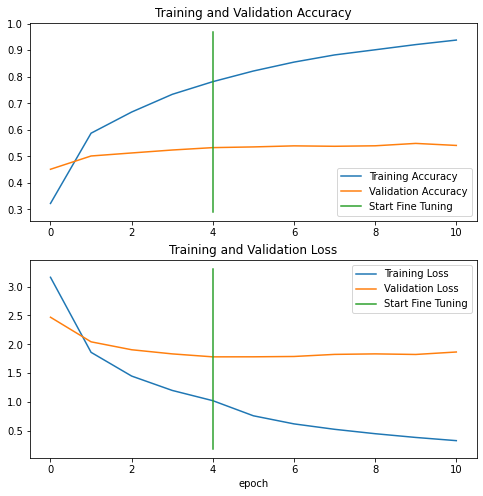

In [ ]:
compare_historys(original_history = history_all_classes_10_percent_nonaug,
                 new_history = history_all_classes_10_percent_fine_tune,
                 initial_epochs=5)

In [ ]:
"""
import tensorflow as tf

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
saved_model_path = "06_101_food_class_10_percent_saved_big_dog_model.zip"
unzip_data(saved_model_path)

model = tf.keras.models.load_model(saved_model_path.split(".")[0])
"""

'\nimport tensorflow as tf\n\n!wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip\nsaved_model_path = "06_101_food_class_10_percent_saved_big_dog_model.zip"\nunzip_data(saved_model_path)\n\nmodel = tf.keras.models.load_model(saved_model_path.split(".")[0])\n'

In [ ]:
loaded_loss, loaded_accuracy = model.evaluate(test_data)
loaded_loss, loaded_accuracy

790/790 [==============================] - 102s 129ms/step - loss: 1.5512 - accuracy: 0.6086


(1.5511746406555176, 0.6085940599441528)

In [ ]:
pred_probs = model.predict(test_data, verbose = 1)


790/790 [==============================] - 98s 122ms/step


In [ ]:
pred_probs.shape

(25250, 101)

In [ ]:
pred_probs[:10]

array([[5.1100880e-01, 9.6030717e-06, 1.1148155e-03, ..., 5.5362161e-06,
        7.4229552e-03, 6.5559726e-03],
       [8.8348323e-01, 1.1616709e-08, 1.2120318e-03, ..., 1.1229696e-03,
        3.0429308e-07, 1.9892307e-06],
       [4.7228047e-01, 2.9750625e-04, 5.4427413e-03, ..., 2.6539175e-04,
        1.1613955e-03, 1.5470932e-03],
       ...,
       [6.2247288e-01, 3.6439030e-08, 1.7952889e-03, ..., 1.0599961e-03,
        1.1452882e-03, 1.2321911e-05],
       [1.5754463e-01, 6.8956761e-05, 1.0138136e-01, ..., 1.3711692e-04,
        3.5485809e-04, 5.5557897e-04],
       [3.7068811e-01, 1.7714843e-08, 1.3247690e-04, ..., 1.2662578e-03,
        4.6875650e-07, 2.8229749e-03]], dtype=float32)

In [ ]:
#for example the prediction probabilities of 0 looks like :
pred_probs[0]

array([5.11008799e-01, 9.60307170e-06, 1.11481547e-03, 3.82131340e-08,
       5.31185151e-07, 1.49679772e-06, 6.99920747e-06, 1.99110104e-07,
       9.73403640e-03, 5.19142122e-05, 4.31611079e-06, 1.61393893e-06,
       9.05970950e-03, 2.32467386e-07, 4.10081958e-03, 2.01431615e-03,
       8.88283466e-05, 9.44425938e-06, 3.89366294e-04, 2.32437355e-06,
       6.95437993e-05, 2.15449763e-05, 1.34313028e-04, 2.81712692e-05,
       7.69252365e-04, 1.19274933e-04, 1.47997274e-03, 5.43552915e-06,
       1.42287491e-02, 2.30684833e-04, 1.13343539e-07, 6.74354087e-05,
       7.22822515e-05, 3.04632053e-08, 1.59706775e-04, 8.06222943e-07,
       1.39329801e-04, 8.06579046e-05, 7.08418852e-03, 6.89231529e-05,
       9.23950502e-05, 7.22376339e-04, 6.18480786e-04, 3.27784210e-06,
       8.02028626e-06, 1.73019071e-05, 5.85844282e-05, 1.62783654e-05,
       5.91075093e-07, 2.47028083e-01, 8.66328483e-04, 7.74782984e-06,
       4.52745333e-02, 6.57014549e-04, 4.04656021e-06, 1.85046531e-03,
      

In [ ]:
pred_classes = pred_probs.argmax(axis = 1)

pred_classes[:10]

array([ 0,  0,  0,  0, 29, 78, 29,  0,  9, 41])

In [ ]:
for images, labels in test_data.unbatch():
  print(images), print(labels), print(labels.numpy().argmax())
  break

tf.Tensor(
[[[ 99.09694  119.09694  189.63776 ]
  [ 76.87755   94.89796  161.13776 ]
  [ 59.33673   71.63776  132.48979 ]
  ...
  [203.       216.       251.      ]
  [203.97449  212.97449  251.97449 ]
  [203.       212.       251.      ]]

 [[112.234695 135.09694  205.14285 ]
  [ 95.36224  114.29591  182.43367 ]
  [ 69.44388   84.44388  146.08673 ]
  ...
  [203.21426  215.42853  252.78574 ]
  [202.92856  214.92856  252.92856 ]
  [202.       214.       254.      ]]

 [[127.56632  152.20918  221.99489 ]
  [105.484695 128.5153   196.5     ]
  [ 82.97449  100.668365 165.94897 ]
  ...
  [202.78572  214.78572  253.12245 ]
  [200.72958  214.51529  254.15816 ]
  [199.78572  212.78572  255.      ]]

 ...

 [[148.2194   166.2194   232.2194  ]
  [146.       164.       230.      ]
  [146.87755  164.7398   230.35715 ]
  ...
  [219.21426  227.       250.64279 ]
  [219.21426  227.21426  250.21426 ]
  [217.57643  225.57643  248.57643 ]]

 [[147.64285  166.64285  232.64285 ]
  [150.92857  168.92857  2

In [ ]:
y_labels = []
for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax())
y_labels[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
len(y_labels)

25250

In [ ]:
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_labels, pred_classes)
sklearn_accuracy


0.6085940594059406

In [ ]:
import numpy as np
sklearn_accuracy - loaded_accuracy

-5.382122525432464e-10

In [ ]:
class_names = test_data.class_names
class_names

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_labels, pred_classes))

              precision    recall  f1-score   support

           0       0.32      0.26      0.29       250
           1       0.67      0.56      0.61       250
           2       0.70      0.60      0.65       250
           3       0.76      0.54      0.63       250
           4       0.56      0.46      0.50       250
           5       0.44      0.43      0.43       250
           6       0.75      0.74      0.75       250
           7       0.77      0.82      0.79       250
           8       0.32      0.40      0.36       250
           9       0.48      0.54      0.51       250
          10       0.44      0.53      0.48       250
          11       0.68      0.60      0.64       250
          12       0.66      0.63      0.64       250
          13       0.54      0.50      0.52       250
          14       0.52      0.53      0.52       250
          15       0.37      0.40      0.38       250
          16       0.66      0.58      0.62       250
          17       0.44    

In [ ]:
classification_report_dict = classification_report(y_labels, pred_classes, output_dict = True)
classification_report_dict

{'0': {'f1-score': 0.28824833702882485,
  'precision': 0.32338308457711445,
  'recall': 0.26,
  'support': 250},
 '1': {'f1-score': 0.6100217864923748,
  'precision': 0.6698564593301436,
  'recall': 0.56,
  'support': 250},
 '10': {'f1-score': 0.4782608695652174,
  'precision': 0.4370860927152318,
  'recall': 0.528,
  'support': 250},
 '100': {'f1-score': 0.6104417670682731,
  'precision': 0.6129032258064516,
  'recall': 0.608,
  'support': 250},
 '11': {'f1-score': 0.6411889596602972,
  'precision': 0.6832579185520362,
  'recall': 0.604,
  'support': 250},
 '12': {'f1-score': 0.6421267893660532,
  'precision': 0.6569037656903766,
  'recall': 0.628,
  'support': 250},
 '13': {'f1-score': 0.5177453027139876,
  'precision': 0.5414847161572053,
  'recall': 0.496,
  'support': 250},
 '14': {'f1-score': 0.5248508946322067,
  'precision': 0.5217391304347826,
  'recall': 0.528,
  'support': 250},
 '15': {'f1-score': 0.3846153846153846,
  'precision': 0.37037037037037035,
  'recall': 0.4,
  's

In [ ]:
classification_report_dict.items()

dict_items([('0', {'precision': 0.32338308457711445, 'recall': 0.26, 'f1-score': 0.28824833702882485, 'support': 250}), ('1', {'precision': 0.6698564593301436, 'recall': 0.56, 'f1-score': 0.6100217864923748, 'support': 250}), ('2', {'precision': 0.6976744186046512, 'recall': 0.6, 'f1-score': 0.6451612903225806, 'support': 250}), ('3', {'precision': 0.7555555555555555, 'recall': 0.544, 'f1-score': 0.6325581395348837, 'support': 250}), ('4', {'precision': 0.5588235294117647, 'recall': 0.456, 'f1-score': 0.5022026431718062, 'support': 250}), ('5', {'precision': 0.43724696356275305, 'recall': 0.432, 'f1-score': 0.43460764587525147, 'support': 250}), ('6', {'precision': 0.75, 'recall': 0.744, 'f1-score': 0.746987951807229, 'support': 250}), ('7', {'precision': 0.7727272727272727, 'recall': 0.816, 'f1-score': 0.7937743190661478, 'support': 250}), ('8', {'precision': 0.31962025316455694, 'recall': 0.404, 'f1-score': 0.3568904593639575, 'support': 250}), ('9', {'precision': 0.48226950354609927

In [ ]:
for k, v in classification_report_dict.items():
  print(k), print(v)

0
{'precision': 0.32338308457711445, 'recall': 0.26, 'f1-score': 0.28824833702882485, 'support': 250}
1
{'precision': 0.6698564593301436, 'recall': 0.56, 'f1-score': 0.6100217864923748, 'support': 250}
2
{'precision': 0.6976744186046512, 'recall': 0.6, 'f1-score': 0.6451612903225806, 'support': 250}
3
{'precision': 0.7555555555555555, 'recall': 0.544, 'f1-score': 0.6325581395348837, 'support': 250}
4
{'precision': 0.5588235294117647, 'recall': 0.456, 'f1-score': 0.5022026431718062, 'support': 250}
5
{'precision': 0.43724696356275305, 'recall': 0.432, 'f1-score': 0.43460764587525147, 'support': 250}
6
{'precision': 0.75, 'recall': 0.744, 'f1-score': 0.746987951807229, 'support': 250}
7
{'precision': 0.7727272727272727, 'recall': 0.816, 'f1-score': 0.7937743190661478, 'support': 250}
8
{'precision': 0.31962025316455694, 'recall': 0.404, 'f1-score': 0.3568904593639575, 'support': 250}
9
{'precision': 0.48226950354609927, 'recall': 0.544, 'f1-score': 0.5112781954887218, 'support': 250}
10


In [ ]:
class_f1_scores = {}

for k,v in classification_report_dict.items():
  if k == "accuracy":
    break
  else:
    class_f1_scores[class_names[int(k)]] = v["f1-score"]

class_f1_scores

{'apple_pie': 0.28824833702882485,
 'baby_back_ribs': 0.6100217864923748,
 'baklava': 0.6451612903225806,
 'beef_carpaccio': 0.6325581395348837,
 'beef_tartare': 0.5022026431718062,
 'beet_salad': 0.43460764587525147,
 'beignets': 0.746987951807229,
 'bibimbap': 0.7937743190661478,
 'bread_pudding': 0.3568904593639575,
 'breakfast_burrito': 0.5112781954887218,
 'bruschetta': 0.4782608695652174,
 'caesar_salad': 0.6411889596602972,
 'cannoli': 0.6421267893660532,
 'caprese_salad': 0.5177453027139876,
 'carrot_cake': 0.5248508946322067,
 'ceviche': 0.3846153846153846,
 'cheese_plate': 0.6212765957446809,
 'cheesecake': 0.36104513064133015,
 'chicken_curry': 0.45965770171149145,
 'chicken_quesadilla': 0.6361655773420479,
 'chicken_wings': 0.7269076305220884,
 'chocolate_cake': 0.4652173913043478,
 'chocolate_mousse': 0.37603993344425957,
 'churros': 0.7719298245614036,
 'clam_chowder': 0.664179104477612,
 'club_sandwich': 0.6883365200764817,
 'crab_cakes': 0.4400785854616896,
 'creme_brul

In [ ]:
import pandas as pd

In [ ]:
f1_scores = pd.DataFrame({"class_name":list(class_f1_scores.keys()),
                          
                          "f1_score": list(class_f1_scores.values())}).sort_values("f1_score", ascending = False)

In [ ]:
f1_scores

,class_name,f1_score
33,edamame,0.950617
63,macarons,0.865424
75,pho,0.846473
32,dumplings,0.840000
69,oysters,0.836653
...,...,...
56,huevos_rancheros,0.359202
8,bread_pudding,0.356890
82,ravioli,0.328482
99,tuna_tartare,0.322344


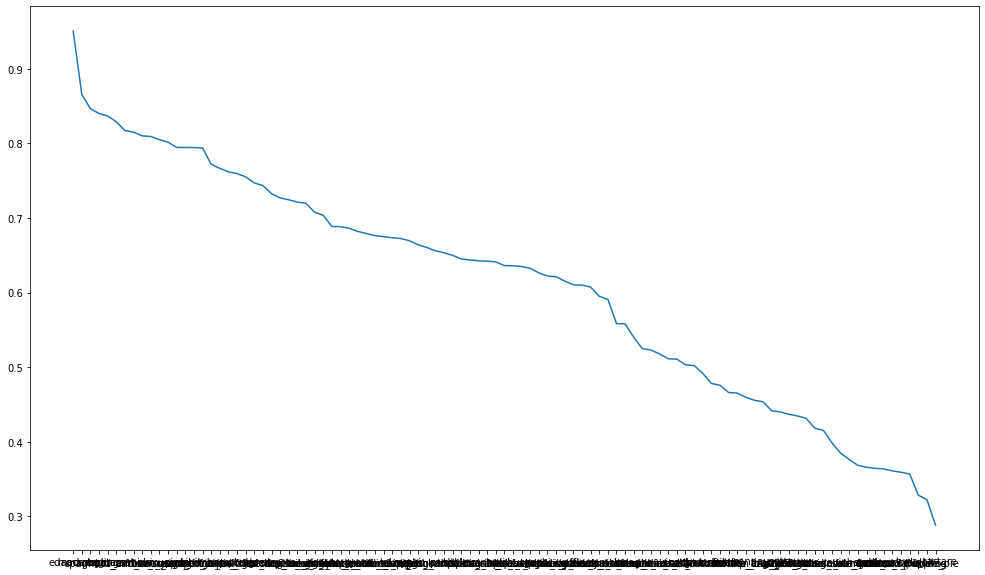

In [ ]:
import matplotlib.pyplot as plt

fix, ax = plt.subplots(figsize=(17,10))
plt.plot(f1_scores["class_name"], f1_scores["f1_score"])

In [ ]:
def load_and_prep_image(filename, img_shape = 224, scale = True ):
  img = tf.io.read_file(filename)
  img = tf.io.decode_image(img)
  img = tf.image.resize(img,[img_shape, img_shape])
  if scale:
    return img/255.
  else:
    return img


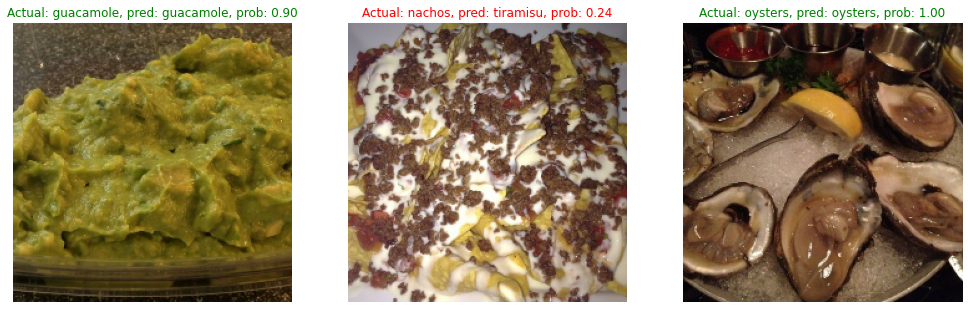

In [ ]:
import os
import random

plt.figure(figsize = (17,10))

for i in range(3):
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(test_dir + "/" + class_name))
  filepath = test_dir + class_name + "/" + filename

  img = load_and_prep_image(filepath, scale = False)
  pred_prob = model.predict(tf.expand_dims(img, axis=0))
  pred_class = class_names[pred_prob.argmax()]

  plt.subplot(1,3,i+1)
  plt.imshow(img/255.)
  if class_name == pred_class:
    title_color = "g"
  else:
    title_color = "r"
  plt.title(f"Actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color)
  plt.axis(False);

In [ ]:
filepaths = []
for filepath in test_data.list_files("101_food_classes_10_percent/test/*/*.jpg",
                                     shuffle = False):
  filepaths.append(filepath.numpy())
filepaths[:10]

[b'101_food_classes_10_percent/test/apple_pie/1011328.jpg',
 b'101_food_classes_10_percent/test/apple_pie/101251.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1034399.jpg',
 b'101_food_classes_10_percent/test/apple_pie/103801.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1038694.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1047447.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1068632.jpg',
 b'101_food_classes_10_percent/test/apple_pie/110043.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1106961.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1113017.jpg']

In [ ]:
import pandas as pd
pred_df = pd.DataFrame({
    "img_path":filepaths,
    "y_true":y_labels,
    "y_pred":pred_classes,
    "pred_conf":pred_probs.max(axis = 1),
    "y_true_classname":[class_names[i] for i in y_labels],
    "y_pred_classname":[class_names[i] for i in pred_classes]
})

pred_df.head()

,img_path,y_true,y_pred,pred_conf,y_true_classname,y_pred_classname
0,b'101_food_classes_10_percent/test/apple_pie/1...,0,0,0.511009,apple_pie,apple_pie
1,b'101_food_classes_10_percent/test/apple_pie/1...,0,0,0.883483,apple_pie,apple_pie
2,b'101_food_classes_10_percent/test/apple_pie/1...,0,0,0.472280,apple_pie,apple_pie
3,b'101_food_classes_10_percent/test/apple_pie/1...,0,0,0.253953,apple_pie,apple_pie
4,b'101_food_classes_10_percent/test/apple_pie/1...,0,29,0.751154,apple_pie,cup_cakes


In [ ]:
pred_df["pred_correct"] = pred_df["y_true"] == pred_df["y_pred"]
pred_df.head()

,img_path,y_true,y_pred,pred_conf,y_true_classname,y_pred_classname,pred_correct
0,b'101_food_classes_10_percent/test/apple_pie/1...,0,0,0.511009,apple_pie,apple_pie,True
1,b'101_food_classes_10_percent/test/apple_pie/1...,0,0,0.883483,apple_pie,apple_pie,True
2,b'101_food_classes_10_percent/test/apple_pie/1...,0,0,0.472280,apple_pie,apple_pie,True
3,b'101_food_classes_10_percent/test/apple_pie/1...,0,0,0.253953,apple_pie,apple_pie,True
4,b'101_food_classes_10_percent/test/apple_pie/1...,0,29,0.751154,apple_pie,cup_cakes,False


In [ ]:
top_100_wrong = pred_df[pred_df["pred_correct"] == False].sort_values("pred_conf", ascending = False)[:100]
top_100_wrong.head(20)

,img_path,y_true,y_pred,pred_conf,y_true_classname,y_pred_classname,pred_correct
10880,b'101_food_classes_10_percent/test/fried_calam...,43,68,0.999251,fried_calamari,onion_rings,False
11252,b'101_food_classes_10_percent/test/frozen_yogu...,45,58,0.999025,frozen_yogurt,ice_cream,False
24740,b'101_food_classes_10_percent/test/tiramisu/89...,98,27,0.998971,tiramisu,creme_brulee,False
23631,b'101_food_classes_10_percent/test/strawberry_...,94,83,0.998749,strawberry_shortcake,red_velvet_cake,False
17208,b'101_food_classes_10_percent/test/onion_rings...,68,43,0.998052,onion_rings,fried_calamari,False
22203,b'101_food_classes_10_percent/test/seaweed_sal...,88,51,0.998002,seaweed_salad,guacamole,False
17995,b'101_food_classes_10_percent/test/paella/9114...,71,65,0.997766,paella,mussels,False
4457,b'101_food_classes_10_percent/test/cheesecake/...,17,94,0.997723,cheesecake,strawberry_shortcake,False
15826,b'101_food_classes_10_percent/test/macarons/19...,63,29,0.997627,macarons,cup_cakes,False
17855,b'101_food_classes_10_percent/test/paella/2314...,71,65,0.997515,paella,mussels,False


In [ ]:
top_100_correct = pred_df[pred_df["pred_correct"] == True].sort_values("pred_conf", ascending = False)[:100]
top_100_correct.head(20)

,img_path,y_true,y_pred,pred_conf,y_true_classname,y_pred_classname,pred_correct
8415,b'101_food_classes_10_percent/test/edamame/330...,33,33,1.0,edamame,edamame,True
16453,b'101_food_classes_10_percent/test/mussels/467...,65,65,1.0,mussels,mussels,True
16301,b'101_food_classes_10_percent/test/mussels/198...,65,65,1.0,mussels,mussels,True
16334,b'101_food_classes_10_percent/test/mussels/240...,65,65,1.0,mussels,mussels,True
5768,b'101_food_classes_10_percent/test/churros/123...,23,23,1.0,churros,churros,True
16496,b'101_food_classes_10_percent/test/mussels/943...,65,65,1.0,mussels,mussels,True
16494,b'101_food_classes_10_percent/test/mussels/935...,65,65,1.0,mussels,mussels,True
8444,b'101_food_classes_10_percent/test/edamame/381...,33,33,1.0,edamame,edamame,True
8299,b'101_food_classes_10_percent/test/edamame/171...,33,33,1.0,edamame,edamame,True
8418,b'101_food_classes_10_percent/test/edamame/334...,33,33,1.0,edamame,edamame,True


Now, its time for celebrations!!...Lets visualise some of the most correct examples 😜

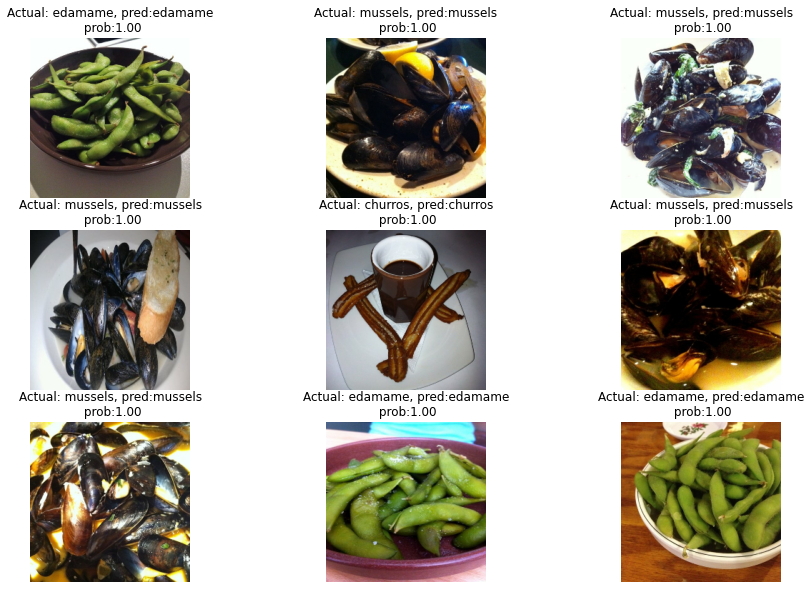

In [ ]:
total_images = 9
start_index = 0
plt.figure(figsize=(15, 10))
for i, row in enumerate(top_100_correct[start_index:start_index+total_images].itertuples()): 
  plt.subplot(3, 3, i+1)
  img = load_and_prep_image(row[1], scale = True)
  _, _, _, _, pred_prob, y_true, y_pred, _ = row
  plt.imshow(img)
  plt.title(f"Actual: {y_true}, pred:{y_pred}\n prob:{pred_prob:.2f}")
  plt.axis(False)

  


 


In [68]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip

unzip_data("custom_food_images.zip")

--2022-03-17 18:14:21--  https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.212.128, 172.217.214.128, 108.177.111.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.212.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13192985 (13M) [application/zip]
Saving to: ‘custom_food_images.zip’

custom_food_images. 100%[===================>]  12.58M  45.8MB/s    in 0.3s    

2022-03-17 18:14:21 (45.8 MB/s) - ‘custom_food_images.zip’ saved [13192985/13192985]



In [70]:
custom_food_images = ["custom_food_images/" + img_path for img_path in os.listdir("custom_food_images")]
custom_food_images

['custom_food_images/chicken_wings.jpeg',
 'custom_food_images/sushi.jpeg',
 'custom_food_images/pizza-dad.jpeg',
 'custom_food_images/hamburger.jpeg',
 'custom_food_images/ramen.jpeg',
 'custom_food_images/steak.jpeg']

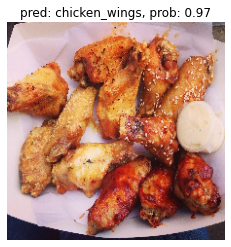

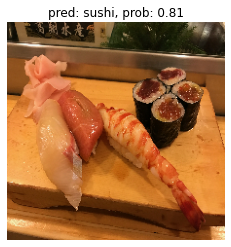

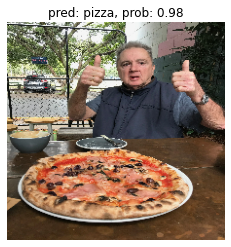

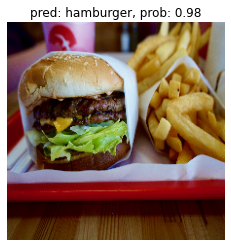

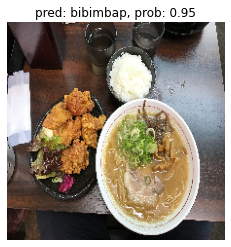

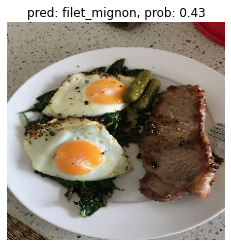

In [71]:
for img in custom_food_images:
  img = load_and_prep_image(img, scale=False) 
  pred_prob = model.predict(tf.expand_dims(img, axis=0)) 
  pred_class = class_names[pred_prob.argmax()] 
  plt.figure()
  plt.imshow(img/255.)
  plt.title(f"pred: {pred_class}, prob: {pred_prob.max():.2f}")
  plt.axis(False)